In [1]:
from matplotlib.colors import Normalize, LogNorm
import contextily as cx # ctx by Damian
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from shapely.ops import unary_union
from xyzservices import TileProvider
import plot_init as pu

In [2]:
# dtypes
# compress dtypes
dtypes_compressed = {
    'datetime': np.object_,    
    'hour': np.int8,
    'month': np.int8,
    'dayofweek': np.int8,
    'number_of_lanes': np.float32,
    
    'speed_limit_kph': np.float32,    
    
    'lon': np.float64,
    'lat': np.float64,
    'elevation': np.int16,    
    'agg_speed': np.float64,  
    
    'pix_business_4x4_200': np.int16,
    'pix_residential_4x4_200': np.int16,
    'pix_industrial_4x4_200': np.int16,
    'pix_institutional_4x4_200': np.int16,
    'pix_business_4x4_50': np.int16,
    'pix_residential_4x4_50': np.int16,
    'pix_industrial_4x4_50': np.int16,
    'pix_institutional_4x4_50': np.int16,
    'pix_business_4x4_100': np.int16,
    'pix_residential_4x4_100': np.int16,
    'pix_industrial_4x4_100': np.int16,
    'pix_institutional_4x4_100': np.int16,
    'pix_business_4x4_150': np.int16,
    'pix_residential_4x4_150': np.int16,
    'pix_industrial_4x4_150': np.int16,
    'pix_institutional_4x4_150': np.int16,
    'pix_business_4x4_250': np.int16,
    'pix_residential_4x4_250': np.int16,
    'pix_industrial_4x4_250': np.int16,
    'pix_institutional_4x4_250': np.int16,
    'pix_business_4x4_500': np.int16,
    'pix_residential_4x4_500': np.int16,
    'pix_industrial_4x4_500': np.int16,
    'pix_institutional_4x4_500': np.int16,
    'pix_business_4x4_1000': np.int16,
    'pix_residential_4x4_1000': np.int16,
    'pix_industrial_4x4_1000': np.int16,
}

def correct_service_rd_kphlimit(temp_df):
    temp_df.loc[temp_df['speed_limit_kph'] == 36.7, 'speed_limit_kph'] = 20
    return temp_df

def impute_lanes(df):
    df['number_of_lanes'] = df['number_of_lanes'].replace(np.nan, value=2)
    return df

def filter_brgy(df):
    df['barangay'] = df['barangay'].fillna('Out-of-town')
    
    # not in cauayan boundary
    df = df.loc[df['barangay'] != 'Out-of-town'] 
    return df

def filter_num_periods(df, thresh):
    df = df.loc[df['num_periods'] >= thresh]
    return df


def filter_vehicles(df, remove_list=None):
    df = df.loc[~df.vehicle_id.isin(remove_list)]
    return df


def prepare_df(df):
    df = df.astype(dtype=dtypes_compressed)
    
    # vehicles with erratic sending of data; stopped sending data before collection date
    remove_list = [
        123200872653, 123200872678, 
        123200872713, 123200872727, 123200872819,
    ] 
    df = filter_brgy(df)
    df = filter_vehicles(df, remove_list=remove_list)
    df = filter_num_periods(df, thresh=12)
    df = impute_lanes(df)
    df = correct_service_rd_kphlimit(df)
    df = df.drop_duplicates()
    return df

In [3]:
# get Cauayan city barangay polygons
root = '/mnt/processed/private/paturo/Geospatial/preprocessing'

admin_bounds_file = os.path.join(root, "admin.zip")
admin_df = gpd.read_file(admin_bounds_file)
admin_df.at[12, "Brgy_Name"] = "Carabatan Bacareno"

# used in tagging vehicle to a barangay
barangay_polygons = admin_df[['Brgy_Name', 'geometry']]
display(admin_df.head(2))

admin_df.crs

Name  descriptio  timestamp  begin  end  altitudeMo  tessellate  extrude  \
0   NaN         NaN        NaN    NaN  NaN         NaN          -1        0   
1   NaN         NaN        NaN    NaN  NaN         NaN          -1        0   

   visibility  drawOrder  icon  Brgy_Name    Area  Population Class  \
0          -1        NaN   NaN  Alicaocao   51.57        1564     R   
1          -1        NaN   NaN     Alinam  330.50        1167     R   

      Region   Area_sqm   Density_sq  \
0  Poblacion   726433.0  2152.985891   
1      Tanap  3026647.0   385.575193   

                                            geometry  
0  POLYGON Z ((121.77603 16.94689 0.00000, 121.77...  
1  POLYGON Z ((121.75682 16.86332 0.00000, 121.75...

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
admin_df.Brgy_Name.unique()

array(['Alicaocao', 'Alinam', 'Amobocan', 'Andarayan', 'Bacolod',
       'Baringin Norte', 'Baringin Sur', 'Buena Suerte', 'Bugallon',
       'Buyon', 'Cabaruan', 'Cabugao', 'Carabatan Bacareno',
       'Carabatan Chica', 'Carabatan Grande', 'Carabatan Punta',
       'Casalatan', 'Cassap Fuera', 'Catalina', 'Culalabat', 'Dabburab',
       'De Vera', 'Dianao', 'Disimuray', 'District 1', 'District 2',
       'District 3', 'Duminit', 'Faustino', 'Gagabutan', 'Gappal',
       'Guayabal', 'Labinab', 'Linglingay', 'Mabantad', 'Maligaya',
       'Manaoag', 'Marabulig I', 'Marabulig II', 'Minante I',
       'Minante II', 'Naganacan', 'Nagcampegan', 'Nagrumbuan',
       'Nungnungan I', 'Nungnungan II', 'Pinoma', 'Rizal', 'Rogus',
       'San Antonio', 'San Fermin', 'San Francisco', 'San Isidro',
       'San Luis', 'San Pablo', 'Santa Luciana', 'Santa Maria',
       'Sillawit', 'Sinippil', 'Tagaran', 'Turayong', 'Union',
       'Villa Concepcion', 'Villa Flor', 'Villa Luna'], dtype=object)

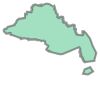

In [5]:
# cauayan boundary
brgy_boundaries = admin_df.geometry.tolist()
cc_boundary = unary_union(brgy_boundaries)
cc_boundary

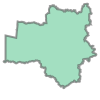

In [6]:
central_barangays = [
    'District 1', 'District 2', 'District 3', 'Cabaruan', 'San Fermin',
]
geoms = [
    admin_df.loc[admin_df.Brgy_Name == i, 'geometry'].values[0] 
    for i in central_barangays
]    
central_region = unary_union(geoms)
central_region

In [7]:
admin_df.crs.to_string()

'EPSG:4326'

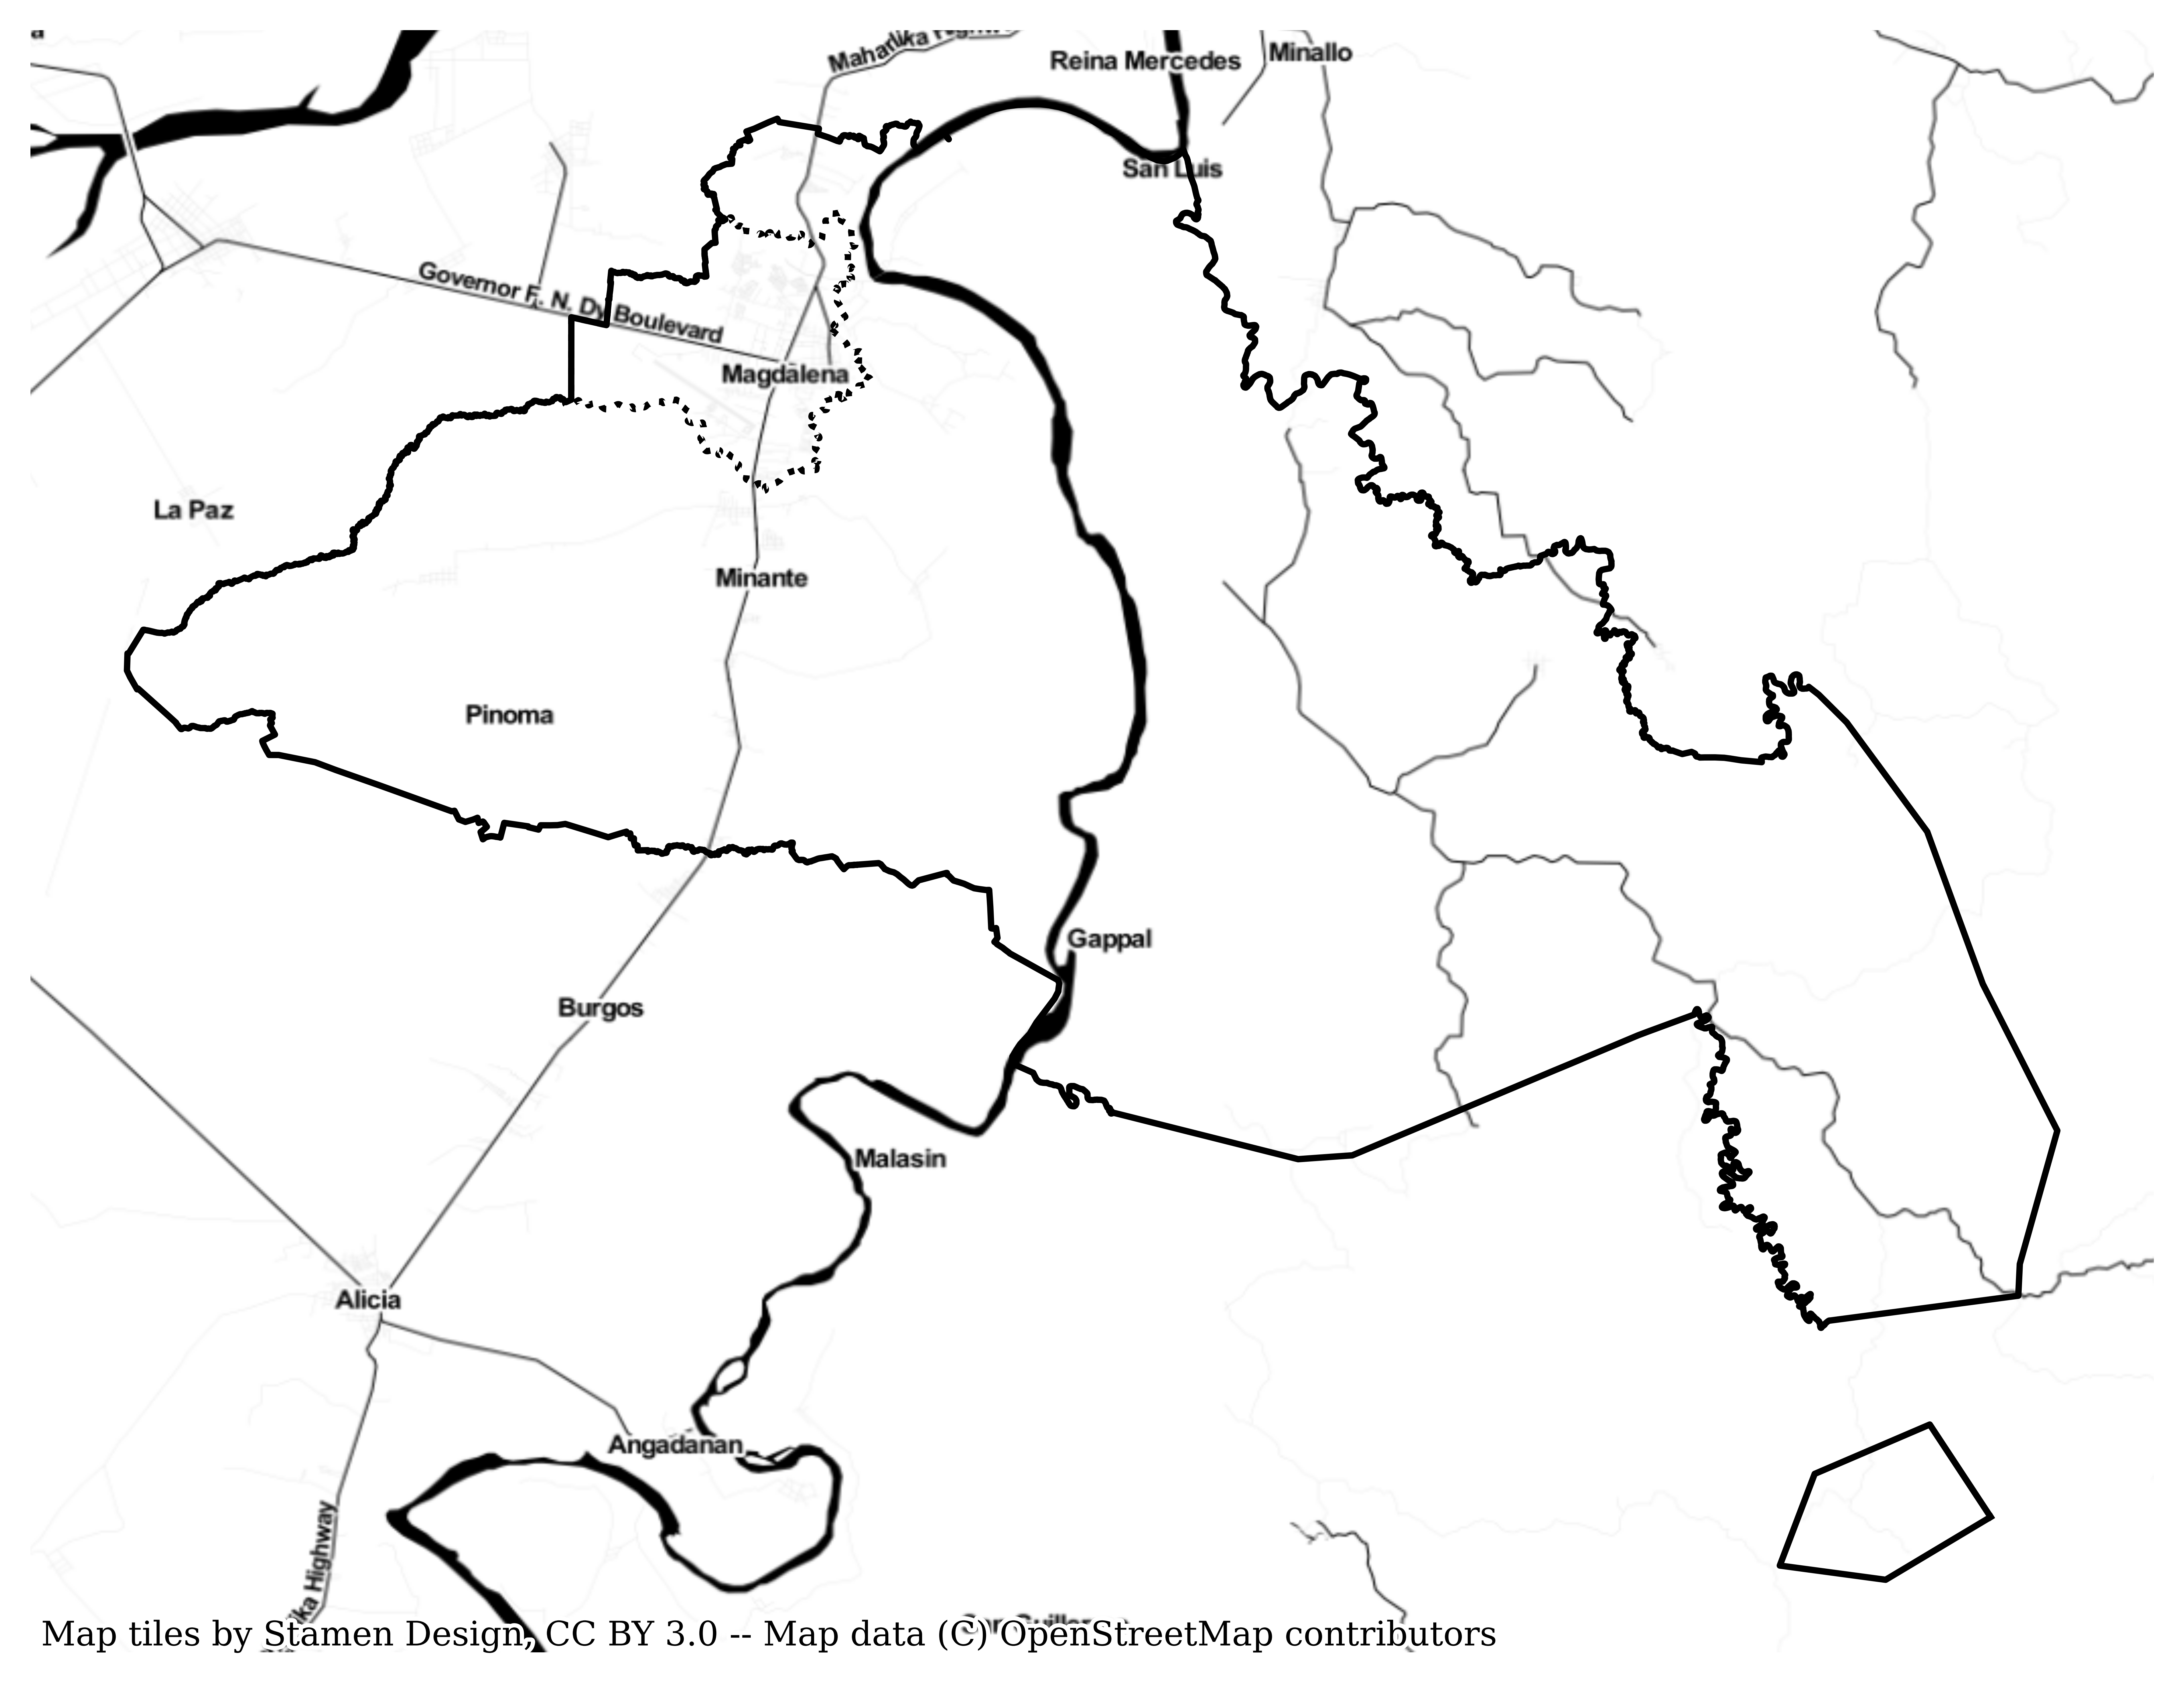

In [8]:
# provider = cx.providers.OpenStreetMap.Mapnik
provider = cx.providers.Stamen.Toner
# provider = cx.providers.CartoDB.PositronNoLabels
# provider = cx.providers.Stadia.AlidadeSmooth
# provider = TileProvider(
#     name="Stadia.AlidadeSmooth",
#     url="https://tiles.stadiamaps.com/tiles/alidade_smooth/{z}/{x}/{y}{r}.png",
#     attribution="(C) Stadia Maps, (C) OpenMapTiles (C) OpenStreetMap contributors",
# )

cc = cx.Place("Cauayan, PH", source=provider)

fig, ax = plt.subplots(figsize=(9,9))

for geom in cc_boundary.geoms:
    ax.plot(*geom.exterior.xy, color='black')
ax.plot(*central_region.exterior.xy, color='black', linestyle="dotted")

cx.add_basemap(
    ax, 
    crs=admin_df.crs.to_string(), 
    source=provider,
)
ax.axis('off')
plt.show()

In [9]:
# load gps traces
src_date = "2023-06-17"

src_dir = f"../datasets/processed/post-review-tt-splits/{src_date}"
train = pd.read_csv(os.path.join(src_dir, "train.csv"))
train = prepare_df(train)

test = pd.read_csv(os.path.join(src_dir, "test.csv"))
test = prepare_df(test)


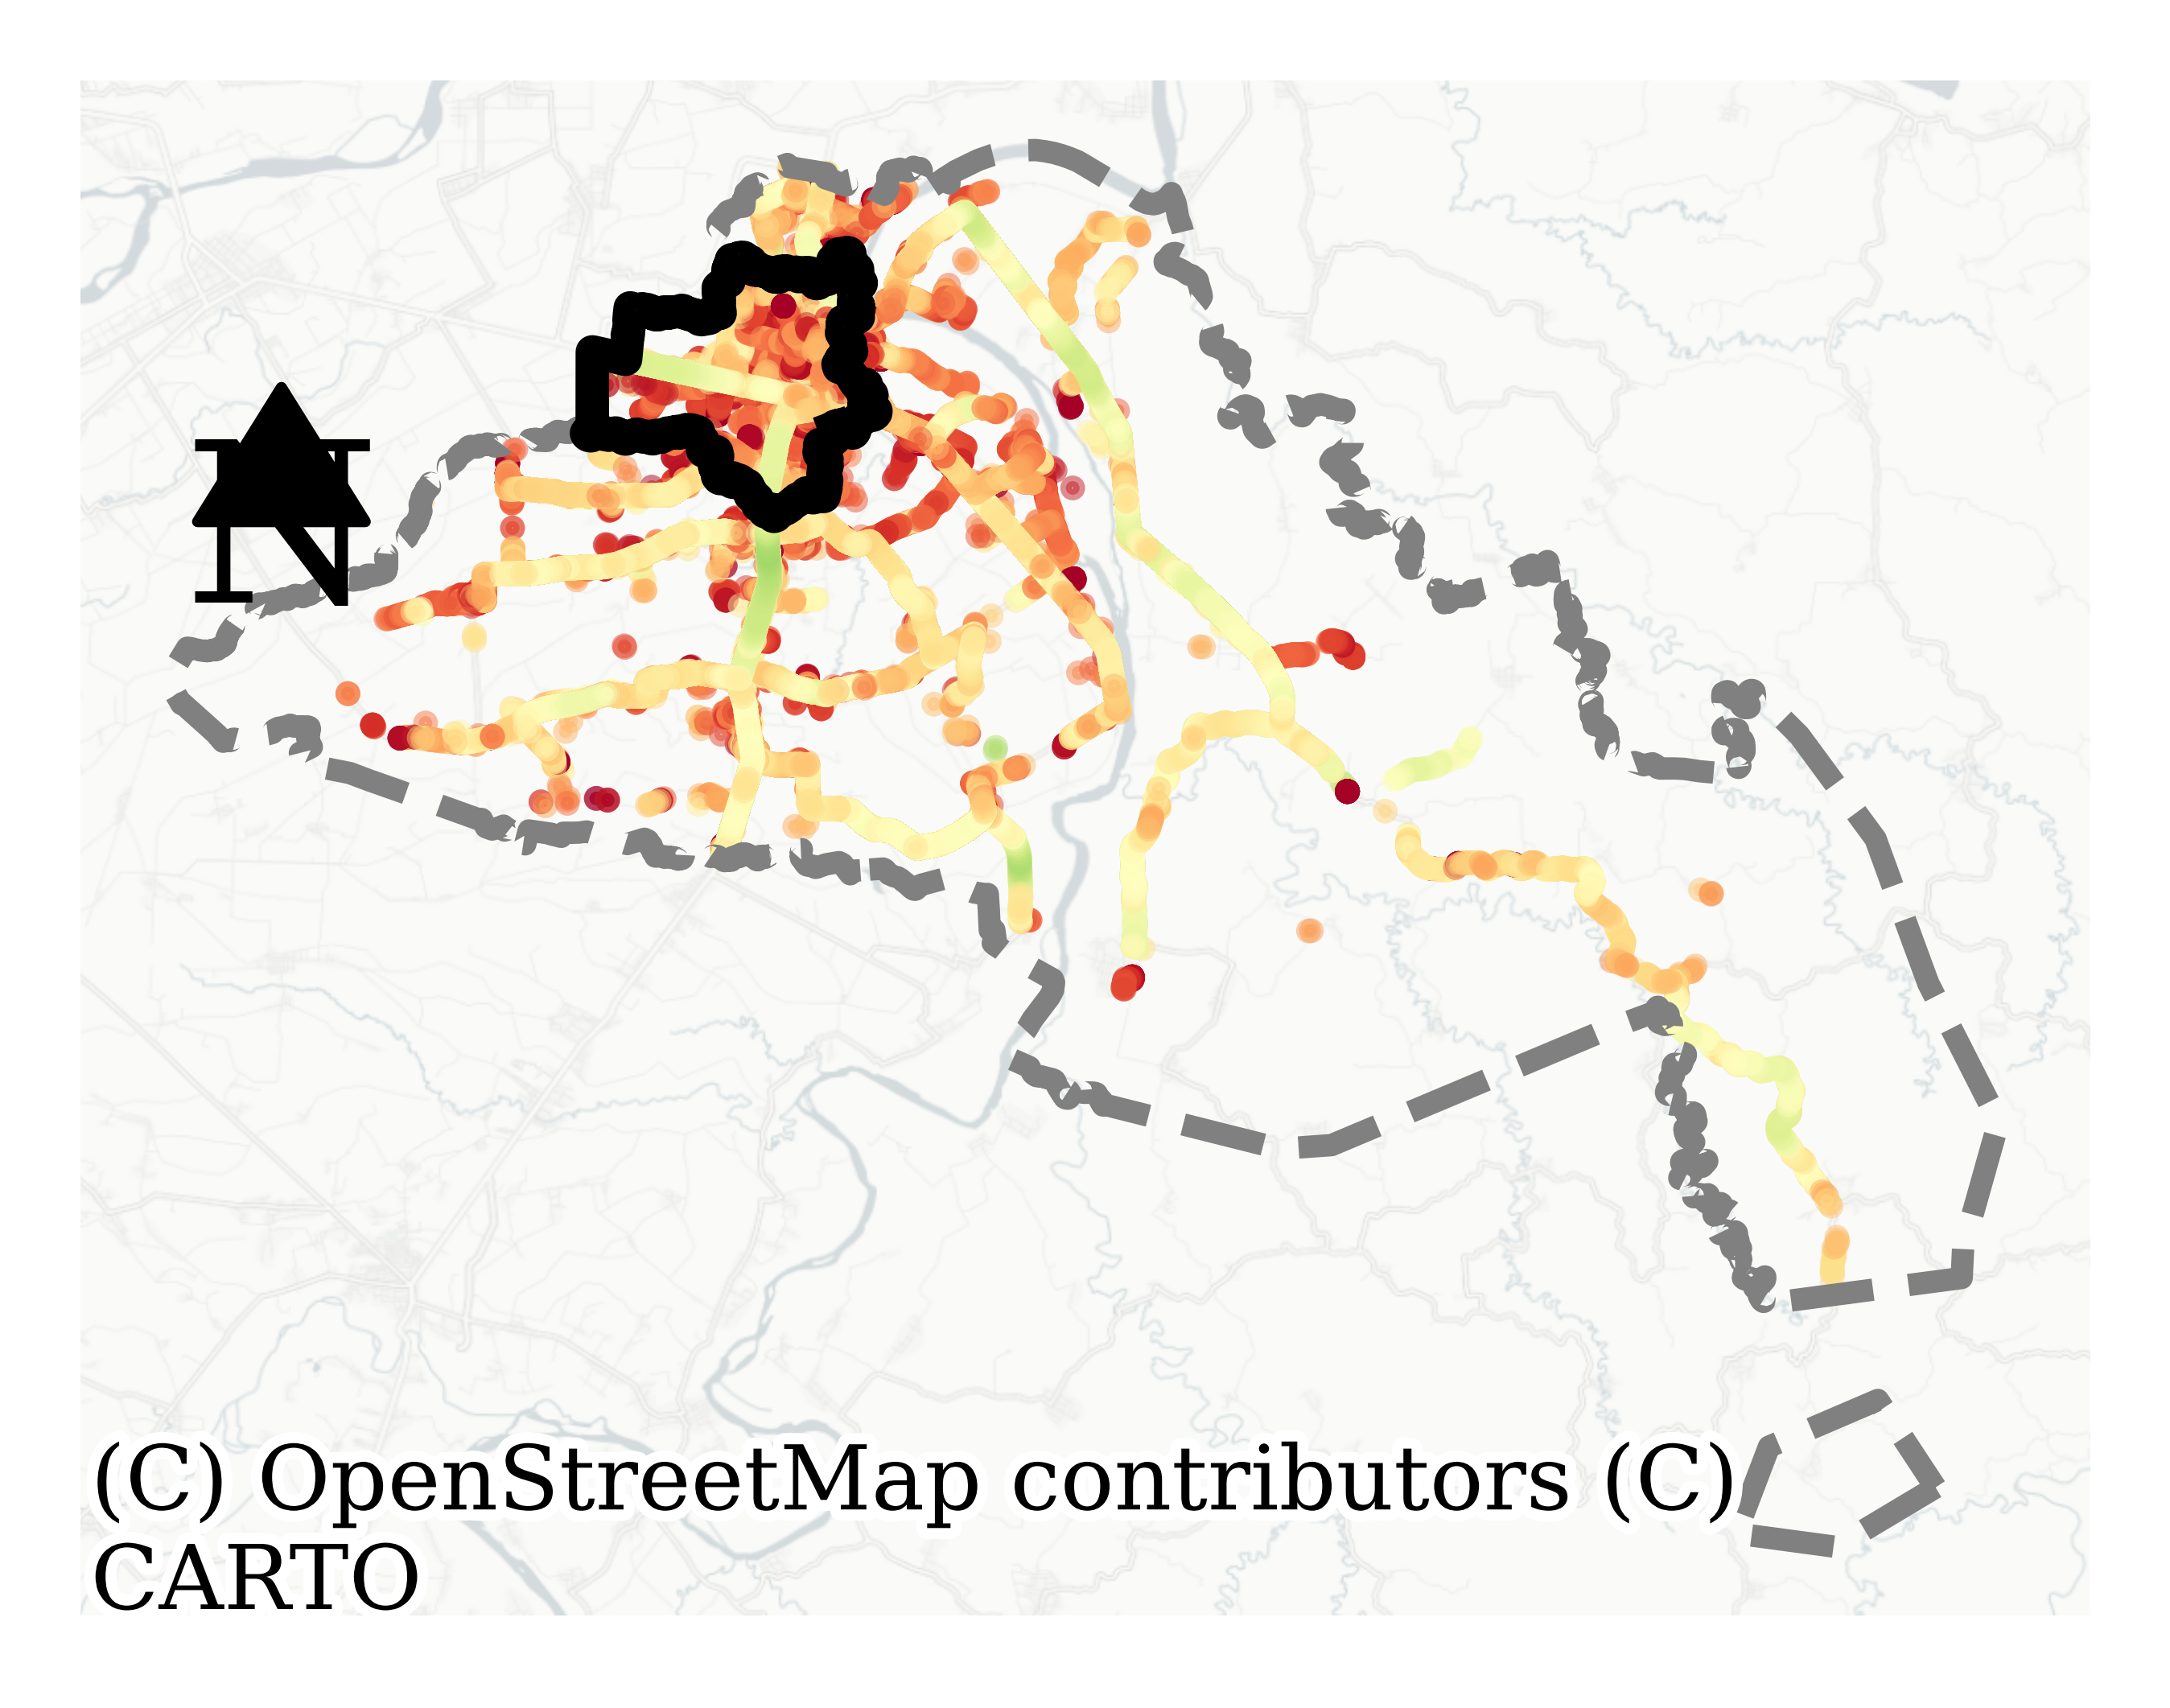

In [10]:
data = train
color_value = 'agg_speed'

provider = cx.providers.CartoDB.PositronNoLabels
cc = cx.Place("Cauayan, PH", source=provider)

fig, ax = plt.subplots(figsize=pu.figsizes['single'])

for geom in cc_boundary.geoms:
    ax.plot(
        *geom.exterior.xy, color='gray', linestyle='dashed', lw=2
    )
    
ax.plot(
    *central_region.exterior.xy, 
    color='black', linestyle="solid", lw=3
)

ax.scatter(
    data['lon'], data['lat'], 
    c=data[color_value],
    alpha=0.5, s=1.5, cmap="RdYlGn",
)
x, y, arrow_length = 0.1, 0.8, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

cx.add_basemap(
    ax, 
    crs=admin_df.crs.to_string(), 
    source=provider,
)

ax.axis('off')
plt.show()